Importovanje potrebnih biblioteka

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sb
import string

Ucitavanje podataka

In [30]:
df = pd.read_csv("../data/synthetic_emotions.csv")

print("Shape:", df.shape) # daje broj redova i kolona
print('\n')

print(df.head()) # daje header i prvih 5 redova
print('\n')

print(df.isnull().sum())

Shape: (13970, 2)


                                                text emotion
0  As the sun dipped below the horizon, painting ...    Love
1  As she gazed into her partner's eyes, a warm g...    Love
2  As she gazed into his eyes, her heart fluttere...    Love
3  The warm rays of sunlight filtering through th...    Love
4  Her eyes sparkled with a radiant warmth as she...    Love


text       0
emotion    0
dtype: int64


Distribucija klasa

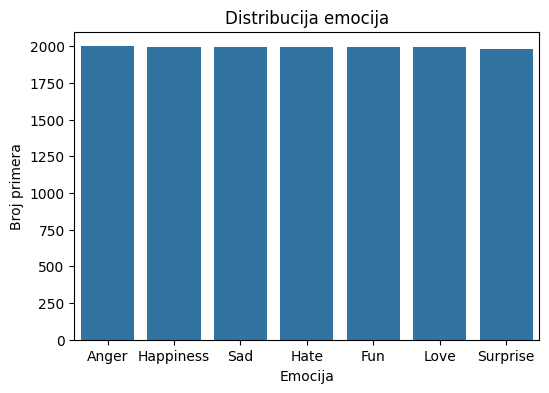

In [31]:
plt.figure(figsize=(6,4))
sb.countplot(data=df, x='emotion', order=df['emotion'].value_counts().index)
plt.title("Distribucija emocija")
plt.xlabel("Emocija")
plt.ylabel("Broj primera")
plt.show()

Duzina tekstova

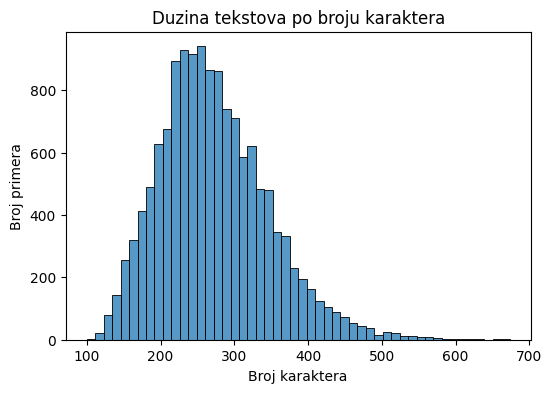

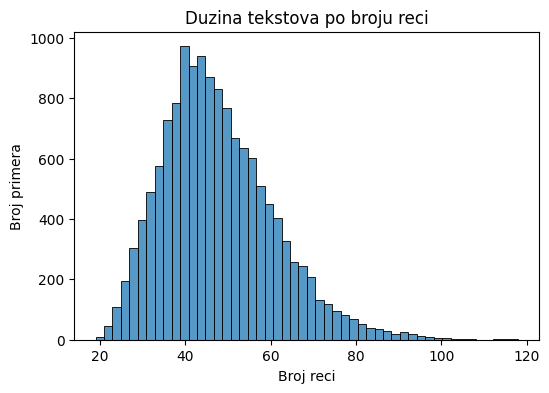

In [32]:
# duzina u karakterima
df['text_length'] = df['text'].apply(len) #ovo ce da doda ovuu kolonu 

plt.figure(figsize=(6,4))
sb.histplot(df['text_length'], bins=50)
plt.title("Duzina tekstova po broju karaktera")
plt.xlabel("Broj karaktera")
plt.ylabel("Broj primera")
plt.show()

# duzina po broju reci
df['word_count'] = df['text'].apply(lambda x: len(x.split())) # ovo ce da doda ovuu kolonu 
plt.figure(figsize=(6,4))
sb.histplot(df['word_count'], bins=50)
plt.title("Duzina tekstova po broju reci")
plt.xlabel("Broj reci")
plt.ylabel("Broj primera")
plt.show()

Duplikati i ciscenje

In [33]:
print("Dupliktai: ", df.duplicated().sum())

#uklanjanje duplikata
df = df.drop_duplicates()

print("Novi shape: ", df.shape)
print(df.head())

Dupliktai:  3
Novi shape:  (13967, 4)
                                                text emotion  text_length  \
0  As the sun dipped below the horizon, painting ...    Love          519   
1  As she gazed into her partner's eyes, a warm g...    Love          251   
2  As she gazed into his eyes, her heart fluttere...    Love          234   
3  The warm rays of sunlight filtering through th...    Love          365   
4  Her eyes sparkled with a radiant warmth as she...    Love          259   

   word_count  
0          92  
1          42  
2          38  
3          61  
4          44  


Najcesce reci po klasi

In [52]:
stopwords = set(['the', 'a', 'an', 'and', 'or', 'to', 'of', 'in', 'on', 'for', 'with', 'as', 'by', 'at', 'from', 'that', 'this', 'it', 'he', 'she', 'his', 'her', 
    'they', 'them', 'is', 'was', 'were', 'be', 'been', 'are', 'am', 'but', 'not', 'you', 'i', 'eyes', 'has', 'had', 'him', 'into', 'every'])

def most_common_words(texts, n=10):
    words = " ".join(texts).lower().split()
    words = [w.translate(str.maketrans('', '', string.punctuation)) for w in words]
    words = [w for w in words if w not in stopwords]
    return Counter(words).most_common(n)

for emotion in df['emotion'].unique():
    print(f"\nNajcesce reci za {emotion}: ")
    print(most_common_words(df[df['emotion']==emotion]['text']))


Najcesce reci za Love: 
[('love', 1913), ('heart', 1911), ('gazed', 1213), ('affection', 1132), ('warmth', 1128), ('sense', 960), ('connection', 899), ('smile', 883), ('seemed', 882), ('felt', 856)]

Najcesce reci za Sad: 
[('heavy', 1399), ('heart', 1276), ('tears', 1274), ('sat', 1243), ('seemed', 1225), ('alone', 955), ('now', 860), ('laughter', 820), ('room', 817), ('sorrow', 795)]

Najcesce reci za Anger: 
[('face', 1956), ('anger', 1357), ('clenched', 1344), ('fists', 1218), ('john', 1200), ('frustration', 841), ('contorted', 797), ('red', 720), ('fist', 717), ('table', 692)]

Najcesce reci za Fun: 
[('laughter', 1754), ('joy', 1526), ('through', 1166), ('john', 1033), ('played', 974), ('echoed', 938), ('room', 818), ('face', 790), ('johns', 769), ('sparkled', 759)]

Najcesce reci za Hate: 
[('face', 1750), ('clenched', 1514), ('fists', 1459), ('hatred', 1081), ('anger', 907), ('contorted', 851), ('intense', 705), ('towards', 685), ('seemed', 639), ('twisted', 620)]

Najcesce re

Raspodela duzina po klasi

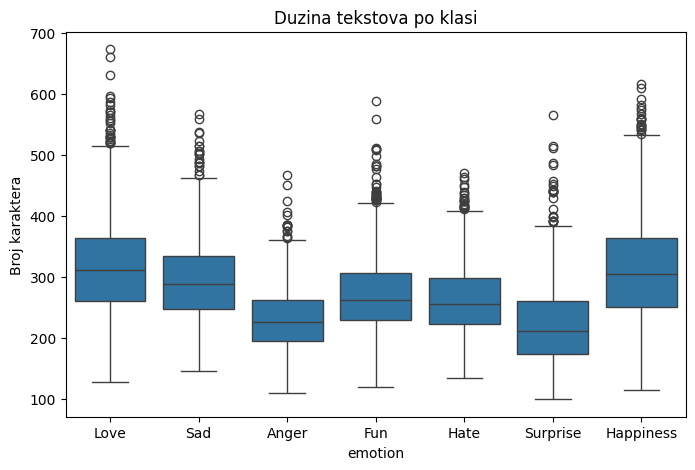

In [35]:
plt.figure(figsize=(8,5))
sb.boxplot(data=df, x='emotion', y='text_length')
plt.title("Duzina tekstova po klasi")
plt.ylabel("Broj karaktera")
plt.show()

Cuvanje ocistenog dataseta

In [36]:
df.to_csv("../data/emotions_cleaned.csv", index=False)